# WGAN(Wassertein GAN)

## GAN
$$L_D^{GAN} = E[log(D(x))] + E[log(1 - D(G(z))]$$

$$L_G^{GAN} = E[log(D(G(z)))]$$


## WGAN
$$L_D^{WGAN} = E[D(x)] - E[D(G(z))]$$

$$L_G^{WGAN} = E[D(G(z))]$$

$$W_D \leftarrow \text{clip_by_value}(W_D, -0.01, 0.01)$$

## WGAN 특징
1. 손실함수가 업데이트된 후에 가중치는 고정된 작은 범위인 **[-c, c]** 사이의 값으로 고정됨
2. Wasserstein distance로부터 유도된 새로운 손실함수를 사용함. discriminator는 직접적인 discriminator의 역할이 아닌 **실제 데이터 분포와 generator의 분포 간에 거리를 추정하는 것을 도와줌**
3. Adam과 같은 모멘텀 기반의 최적화를 사용하는 것이 아닌 RMSProp을 사용하는 것을 추천했음(실험적인 결과)

### Wasserstein distance
- 두 확률분포간의 거리를 측정하는 지표. **Earth Mover's distance**, EM distance라고 불림
- 어떤 확률 분포 모양을 띄는 흙더미를 다른 확률분포 모양을 가지도록 하는데 드는 **최소 비용**
    - 비용 : **옮겨진 흙의 양**과 **이동한 거리**를 곱
- 확률분포에서의 Wasserstein distance
    - 이산확률분포 : $W = \sum |\delta_u | $
    - 연속확률분포 : $W(p_r, p_g) = \inf_{\gamma \sim (P_r, P_g)} E_{(x, y) \sim \gamma} [\| x - y \|]$
    
    

## 1. Import Libs

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.utils import make_grid

import gzip
import time
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

USE_CUDA = torch.cuda.is_available()

## 2. Setting hyperparameters

In [2]:
num_epochs = 30
learning_rate = 0.0002
batch_size = 64
z_dim = 62
sample_num = 64
beta1 = 0.5
beta2 = 0.999
c = 0.01
n_critics = 5

result_dir = './save_results/MNIST/WGAN'
model_dir = './save_models/MNIST/WGAN'

if not os.path.exists(result_dir):
    os.mkdir(result_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

## 3. Load dataset

In [3]:
def load_mnist(dataset):
    data_dir = os.path.join("./data", dataset)
    
    def extract_data(filename, num_data, head_size, data_size):
        with gzip.open(filename) as bytestream:
            bytestream.read(head_size)
            buf = bytestream.read(data_size * num_data)
            data = np.frombuffer(buf, dtype=np.uint8).astype(np.float)
        return data

    data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
    trX = data.reshape((60000, 28, 28, 1))

    data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
    trY = data.reshape((60000))

    data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
    teX = data.reshape((10000, 28, 28, 1))

    data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
    teY = data.reshape((10000))

    trY = np.asarray(trY).astype(np.int)
    teY = np.asarray(teY)

    X = np.concatenate((trX, teX), axis=0)
    y = np.concatenate((trY, teY), axis=0).astype(np.int)

    seed = 547
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(y)

    y_vec = np.zeros((len(y), 10), dtype=np.float)
    for i, label in enumerate(y):
        y_vec[i, y[i]] = 1

    X = X.transpose(0, 3, 1, 2) / 255.
    # y_vec = y_vec.transpose(0, 3, 1, 2)

    X = torch.from_numpy(X).type(torch.FloatTensor)
    y_vec = torch.from_numpy(y_vec).type(torch.FloatTensor)
    return X, y_vec

In [4]:
data_X, _ = load_mnist("MNIST")

print(data_X.size())
print(data_X.__getitem__(11).size())

torch.Size([70000, 1, 28, 28])
torch.Size([1, 28, 28])


## 4. Build Models
### 4.1 Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, input_height, input_width, input_dim, output_dim):
        super(Generator, self).__init__()
        self.input_height = input_height
        self.input_width = input_width
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Sigmoid(),
        )
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_height // 4), (self.input_width // 4))
        x = self.deconv(x)
        return x

### 4.2 Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_height, input_width, input_dim, output_dim):
        super(Discriminator, self).__init__()
        self.input_height = input_height
        self.input_width = input_width
        self.input_dim = input_dim # 1
        self.output_dim = output_dim
        
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_height // 4) * (self.input_width // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid()
        )
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 128 * (self.input_height // 4) * (self.input_width // 4))
        x = self.fc(x)
        return x

## utils

In [7]:
def loss_plot(hist, path = 'Train_hist.png', model_name = ''):
    x = range(len(hist['d_loss']))

    y1 = hist['d_loss']
    y2 = hist['g_loss']

    plt.plot(x, y1, label='d_loss')
    plt.plot(x, y2, label='g_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')

    plt.savefig(path)

    plt.close()

## 5. Models

In [8]:
G = Generator(28, 28, z_dim, 1)
D = Discriminator(28, 28, 1, 1)
G.initialize_weights()
D.initialize_weights()

sample_z = torch.randn((sample_num, z_dim), requires_grad=False)
    
g_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=(beta1, beta2))
d_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=(beta1, beta2))

if USE_CUDA:
    G = G.cuda()
    D = D.cuda()
    sample_z = sample_z.cuda()

## 6. Load Models

In [9]:
try:
    G.load_state_dict(torch.load(model_dir + '/wgan_generator.pkl'))
    D.load_state_dict(torch.load(model_dir + '/wgan_discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model not restored--------



In [10]:
print(G)
print(D)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=62, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)
Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

## 7. Train

$$L_D^{WGAN} = E[D(x)] - E[D(G(z))]$$

$$L_G^{WGAN} = E[D(G(z))]$$

$$W_D \leftarrow \text{clip_by_value}(W_D, -0.01, 0.01)$$

In [11]:
train_hist = {}
train_hist['d_loss'] = []
train_hist['g_loss'] = []
train_hist['per_epoch_time'] = []
train_hist['total_time'] = []

real_labels = torch.ones(batch_size, 1)
fake_labels = torch.zeros(batch_size, 1)

if USE_CUDA:
    real_labels =  real_labels.cuda()
    fake_labels = fake_labels.cuda()

In [12]:
D.train()
print('training start!!')
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    G.train()
    epoch_start_time = time.time()
    
    for iter in range(len(data_X) // batch_size):
        images = data_X[iter*batch_size:(iter+1)*batch_size]
        
        z = torch.rand((batch_size, z_dim))

        if USE_CUDA:
            images = images.cuda() 
            z = z.cuda()
            
        #============= Train the discriminator =============#
        # update D network
        d_optimizer.zero_grad()
        
        d_real = D(images)
        d_loss_real = -torch.mean(d_real)
            
        fake_images = G(z)
        d_fake = D(fake_images)
        
        # 손실함수를 mean으로 설정
        d_loss_fake = torch.mean(d_fake)
        
        d_loss = d_loss_real + d_loss_fake
        
        """ Grandient Penalty
        if USE_CUDA:
            alpha = torch.rand(x_.size()).cuda()
        else:
            alpha = torch.rand(x_.size())
        
        x_hat = Variable(alpha * x_.data + (1 - alpha) * G_.data, requires_grad=True)
        
        pred_hat = D(x_hat)
        
        if USE_CUDA:
            gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()).cuda(),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
        else:
            gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
        
        gradient_penalty = lambda_ * ((gradients.view(gradients.size()[0], -1).norm(2, 1) - 1) ** 2).mean()
        
        D_loss = D_real_loss + D_fake_loss + gradient_penalty
        """
        
        d_loss.backward()
        d_optimizer.step()
        
        # clipping D
        for p in D.parameters():
            p.data.clamp_(-c, c)
            
        if ((iter + 1) % n_critics) == 0:
            # update G network
            g_optimizer.zero_grad()
            
            fake_images = G(z)
            d_fake = D(fake_images)
            g_loss = -torch.mean(d_fake)
            train_hist['g_loss'].append(g_loss.item())
            
            g_loss.backward()
            g_optimizer.step()
            train_hist['d_loss'].append(d_loss.item())
            
        
        if ((iter + 1) % 100) == 0:
            print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
                  %(epoch, num_epochs, (iter + 1), len(data_X) // batch_size, d_loss.item(), g_loss.item()))
            
    train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
    
    # Save
    G.eval()

    # Save sample images
    samples = G(sample_z)
    generated_sample = samples.view(sample_num, 1, 28, 28)
    save_image(generated_sample.data, result_dir + '/generated_images-%d.png'%(epoch + 1))
    
train_hist['total_time'].append(time.time() - start_time)
print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(train_hist['per_epoch_time']), num_epochs, train_hist['total_time'][0]))

torch.save(G.state_dict(), model_dir + '/wgan_generator.pkl')
torch.save(D.state_dict(), model_dir + '/wgan_discriminator.pkl')

loss_plot(train_hist, result_dir, 'WGAN')

training start!!
Epoch [1/30], Step [100/1093], D_loss: -0.0043, G_loss: -0.4985
Epoch [1/30], Step [200/1093], D_loss: -0.0046, G_loss: -0.4978
Epoch [1/30], Step [300/1093], D_loss: -0.0045, G_loss: -0.4977
Epoch [1/30], Step [400/1093], D_loss: -0.0046, G_loss: -0.4975
Epoch [1/30], Step [500/1093], D_loss: -0.0045, G_loss: -0.4976
Epoch [1/30], Step [600/1093], D_loss: -0.0046, G_loss: -0.4975
Epoch [1/30], Step [700/1093], D_loss: -0.0045, G_loss: -0.4976
Epoch [1/30], Step [800/1093], D_loss: -0.0046, G_loss: -0.4975
Epoch [1/30], Step [900/1093], D_loss: -0.0046, G_loss: -0.4974
Epoch [1/30], Step [1000/1093], D_loss: -0.0047, G_loss: -0.4975
Epoch [2/30], Step [100/1093], D_loss: -0.0045, G_loss: -0.4975
Epoch [2/30], Step [200/1093], D_loss: -0.0046, G_loss: -0.4976
Epoch [2/30], Step [300/1093], D_loss: -0.0047, G_loss: -0.4975
Epoch [2/30], Step [400/1093], D_loss: -0.0048, G_loss: -0.4974
Epoch [2/30], Step [500/1093], D_loss: -0.0047, G_loss: -0.4975
Epoch [2/30], Step [60

Epoch [13/30], Step [800/1093], D_loss: -0.0016, G_loss: -0.4984
Epoch [13/30], Step [900/1093], D_loss: -0.0015, G_loss: -0.4987
Epoch [13/30], Step [1000/1093], D_loss: -0.0019, G_loss: -0.4985
Epoch [14/30], Step [100/1093], D_loss: -0.0014, G_loss: -0.4990
Epoch [14/30], Step [200/1093], D_loss: -0.0020, G_loss: -0.4988
Epoch [14/30], Step [300/1093], D_loss: -0.0016, G_loss: -0.4987
Epoch [14/30], Step [400/1093], D_loss: -0.0014, G_loss: -0.4986
Epoch [14/30], Step [500/1093], D_loss: -0.0018, G_loss: -0.4989
Epoch [14/30], Step [600/1093], D_loss: -0.0014, G_loss: -0.4989
Epoch [14/30], Step [700/1093], D_loss: -0.0018, G_loss: -0.4989
Epoch [14/30], Step [800/1093], D_loss: -0.0014, G_loss: -0.4988
Epoch [14/30], Step [900/1093], D_loss: -0.0017, G_loss: -0.4986
Epoch [14/30], Step [1000/1093], D_loss: -0.0019, G_loss: -0.4983
Epoch [15/30], Step [100/1093], D_loss: -0.0017, G_loss: -0.4985
Epoch [15/30], Step [200/1093], D_loss: -0.0018, G_loss: -0.4985
Epoch [15/30], Step [30

Epoch [26/30], Step [400/1093], D_loss: -0.0012, G_loss: -0.4988
Epoch [26/30], Step [500/1093], D_loss: -0.0008, G_loss: -0.4993
Epoch [26/30], Step [600/1093], D_loss: -0.0012, G_loss: -0.4988
Epoch [26/30], Step [700/1093], D_loss: -0.0010, G_loss: -0.4992
Epoch [26/30], Step [800/1093], D_loss: -0.0010, G_loss: -0.4990
Epoch [26/30], Step [900/1093], D_loss: -0.0009, G_loss: -0.4990
Epoch [26/30], Step [1000/1093], D_loss: -0.0013, G_loss: -0.4986
Epoch [27/30], Step [100/1093], D_loss: -0.0010, G_loss: -0.4993
Epoch [27/30], Step [200/1093], D_loss: -0.0011, G_loss: -0.4991
Epoch [27/30], Step [300/1093], D_loss: -0.0013, G_loss: -0.4991
Epoch [27/30], Step [400/1093], D_loss: -0.0011, G_loss: -0.4994
Epoch [27/30], Step [500/1093], D_loss: -0.0013, G_loss: -0.4989
Epoch [27/30], Step [600/1093], D_loss: -0.0011, G_loss: -0.4988
Epoch [27/30], Step [700/1093], D_loss: -0.0010, G_loss: -0.4992
Epoch [27/30], Step [800/1093], D_loss: -0.0009, G_loss: -0.4993
Epoch [27/30], Step [900

## 8. Display generated data

In [13]:
import imageio

images = []
for epoch in range(num_epochs + 1):
    try:
        img_name = result_dir + '/generated_images-%d.png'%(epoch + 1)
        images.append(imageio.imread(img_name))
    except:
        pass
    
imageio.mimsave(result_dir + '/fake_images_total.gif', images, fps=4)


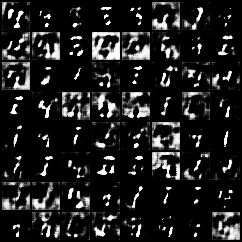

In [14]:
import io
import base64
from IPython.display import HTML

video = io.open(result_dir + '/fake_images_total.gif', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

## 9. Use models to generate new sample

In [15]:
try:
    G.load_state_dict(torch.load(model_dir + '/wgan_generator.pkl'))
    D.load_state_dict(torch.load(model_dir + '/wgan_discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



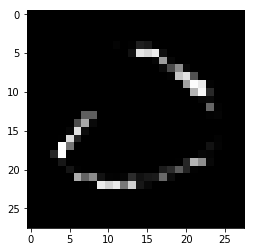

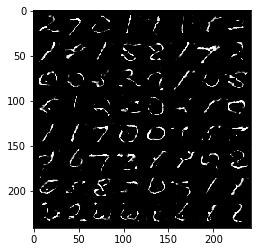

In [16]:
z = torch.randn(sample_num, z_dim)

if USE_CUDA:
    z = z.cuda()
    
fake_images = G(z)
plt.imshow(fake_images[2].cpu().view(28, 28).data.numpy(), cmap='gray')
plt.show()

plt.imshow(make_grid(fake_images.data.view(sample_num,1,28,28)).cpu().permute(1,2,0).numpy())
plt.show()